## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.


Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course \


Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

<>:2: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_5378/2367876760.py:2: SyntaxWarning: invalid escape sequence '\g'
  """


# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

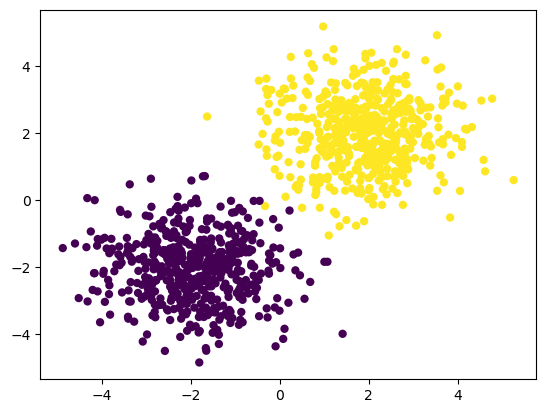

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [32]:
net = Sequential()
net.add(Linear(2, 8))
net.add(ReLU())
net.add(Linear(8, 2))
net.add(LogSoftMax())
criterion = ClassNLLCriterion()

In [4]:

net = Sequential()
net.add(Linear(2, 8))
net.add(ReLU())
net.add(Linear(8, 2))
net.add(LogSoftMax())
criterion = ClassNLLCriterion()
print(net)



Linear 2 -> 8
ReLU
Linear 8 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 256

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 256


# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

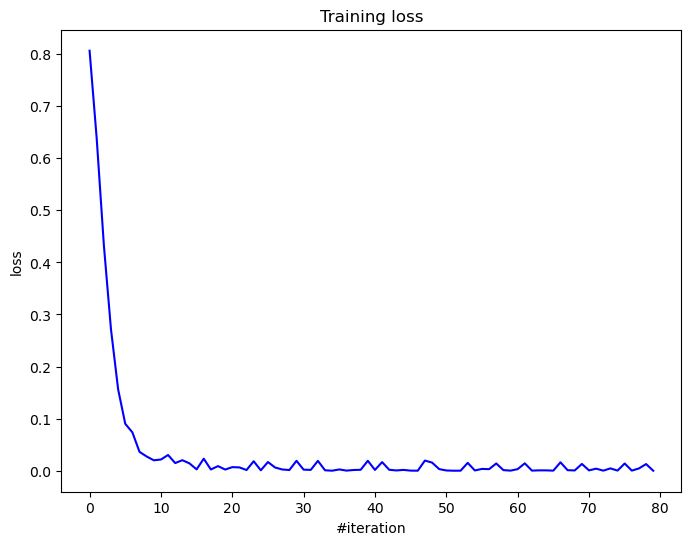

Current loss: 0.000125


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

In [8]:
output = net.forward(X)
predictions = np.argmax(output, axis=1)
true_labels = np.argmax(Y, axis=1)

# Вычисление точности
accuracy = np.mean(predictions == true_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 99.80%


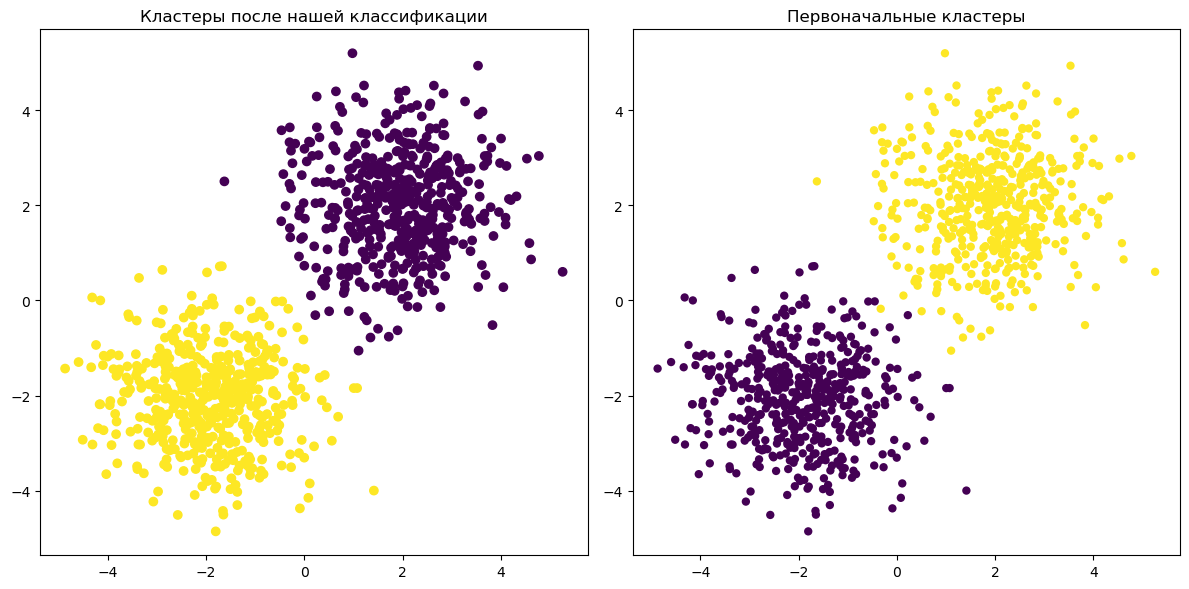

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Первый scatterplot
ax1.scatter(X[:, 0], X[:, 1], c=predictions)
ax1.set_title("Кластеры после нашей классификации")


# Второй scatterplot
ax2.scatter(X[:, 0], X[:, 1], c = Y[:,0], edgecolors='none')
ax2.set_title("Первоначальные кластеры")


# Отображаем графики
plt.tight_layout()
plt.show()

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [ ]:
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

Файл ‘mnist.py’ уже существует — не загружается.



In [10]:
import numpy as np
import struct
from array import array


def read_images_labels(images_filepath, labels_filepath):        
    labels = []
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        labels = array("B", file.read())        
    
    with open(images_filepath, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        image_data = array("B", file.read())        
    images = []
    for i in range(size):
        images.append([0] * rows * cols)
    for i in range(size):
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        images[i][:] = img            
    
    return images, labels
    

In [11]:
train_images, train_labels = read_images_labels("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
test_images, test_labels = read_images_labels("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

X_train, X_val = train_images[:-10000], test_images[-10000:]
y_train, y_val = train_labels[:-10000], test_labels[-10000:]


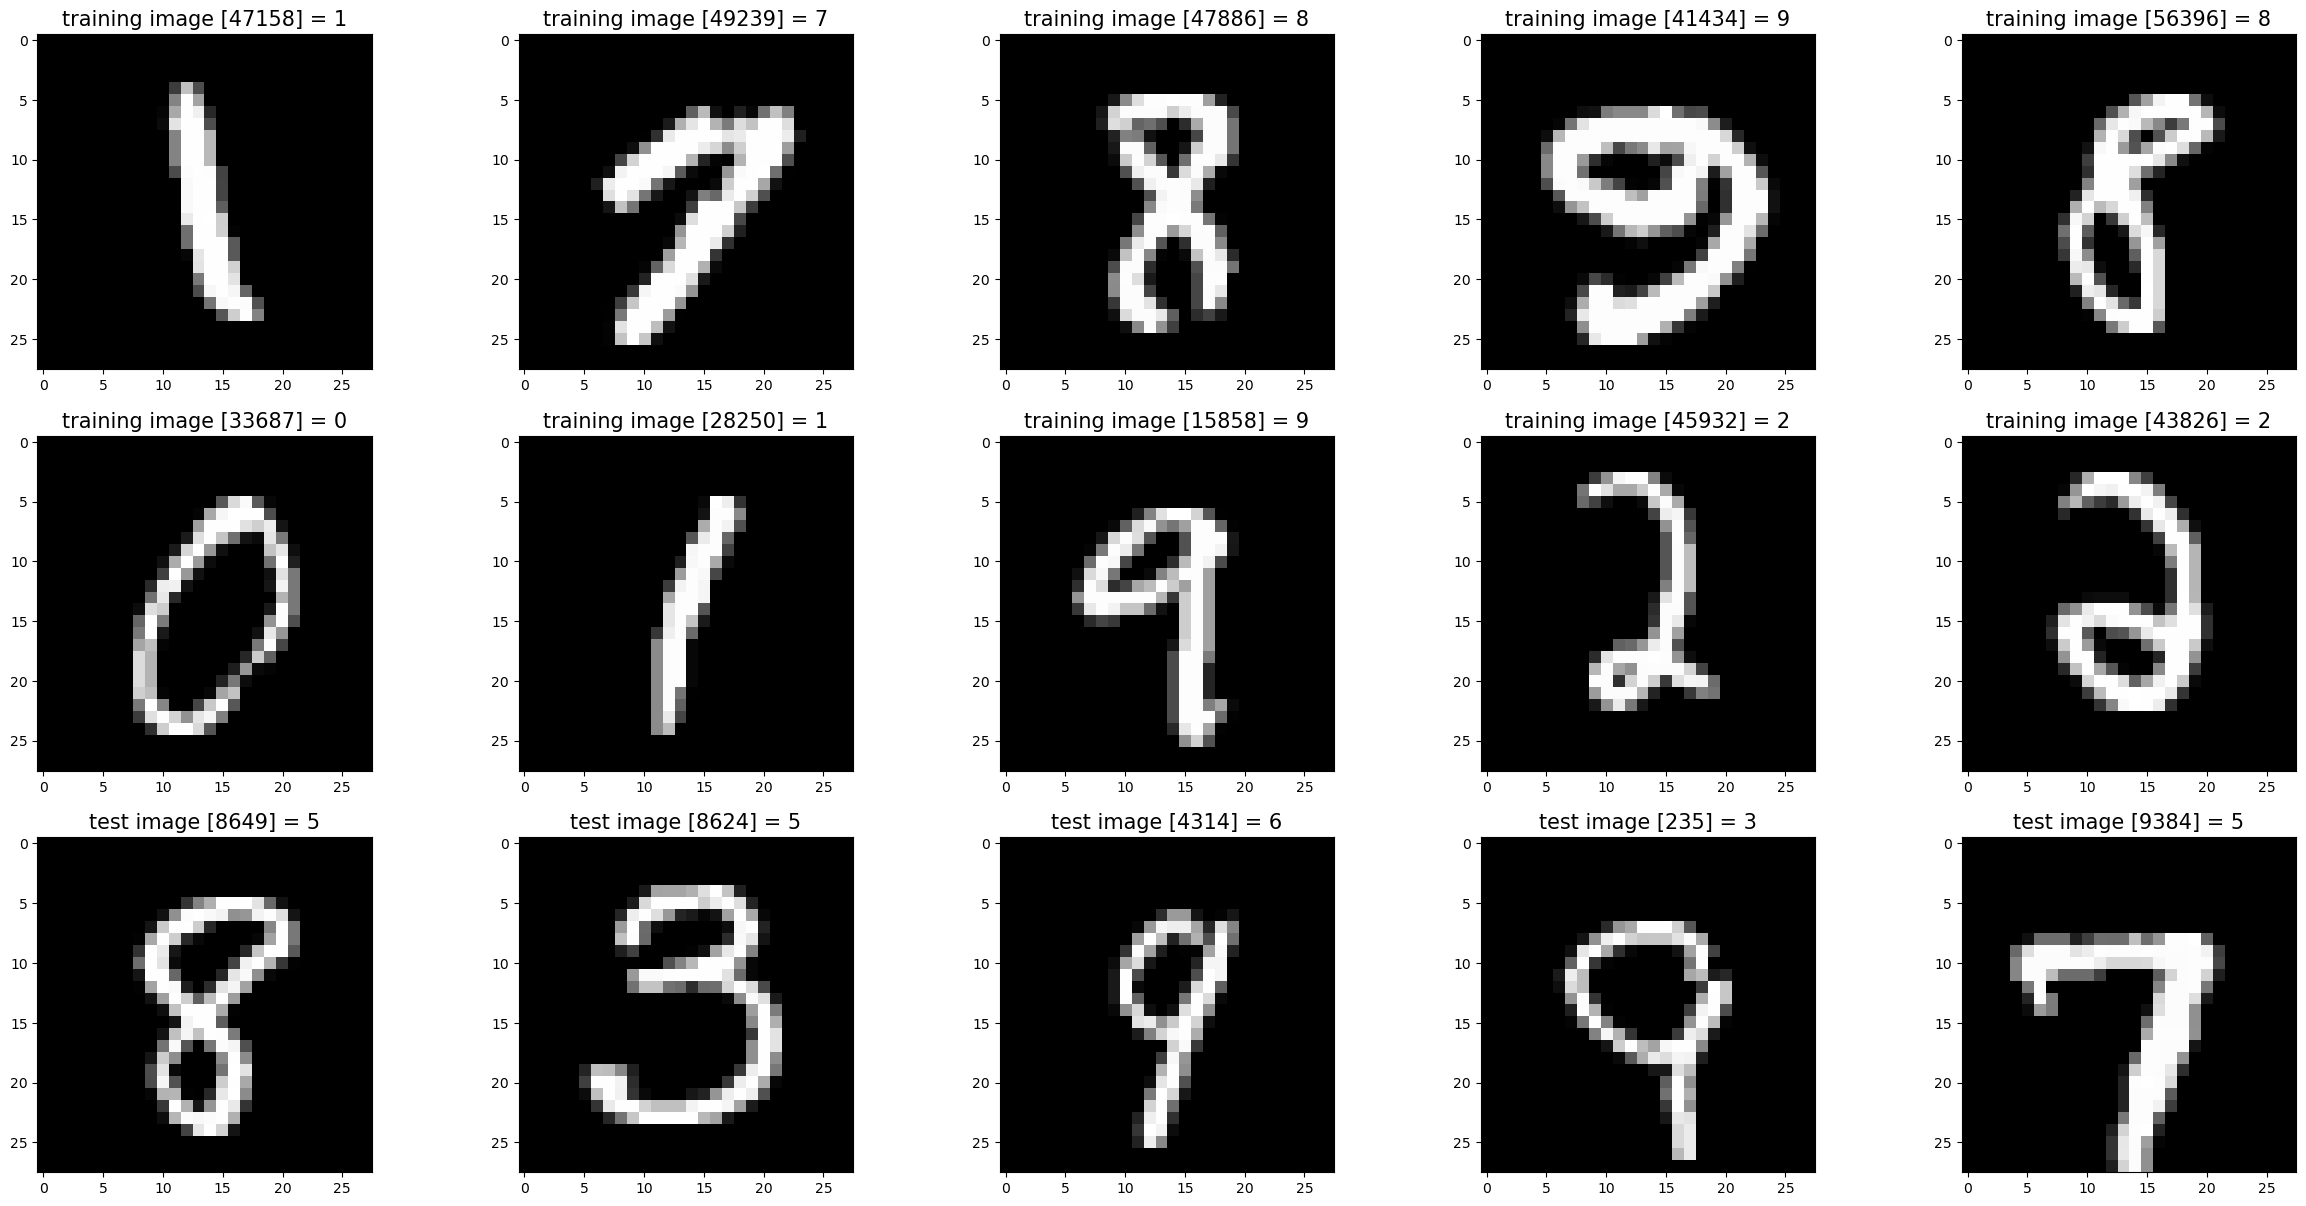

In [12]:
#
# Verify Reading Dataset via MnistDataloader class
#
import random
import matplotlib.pyplot as plt

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1


images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(train_images[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(train_labels[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(test_images[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(train_labels[r]))    

show_images(images_2_show, titles_2_show)

One-hot encode the labels first.

In [13]:
# Your code goes here. ################################################

X_train = np.array(train_images) / 255
X_val = np.array(test_images) / 255
y_train = np.array(train_labels)
y_val = np.array(test_labels)


def one_hot(labels, num_classes=10):
    ohe = np.zeros((labels.size, num_classes))
    ohe[np.arange(labels.size), labels] = 1
    return ohe



y_train = one_hot(y_train)
y_val = one_hot(y_val)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [14]:
# Модель с акативацией ReLU
model_relu = Sequential()
model_relu.add(Flatten())
model_relu.add(Linear(784, 392))
model_relu.add(BatchNormalization())
model_relu.add(ChannelwiseScaling(392))
model_relu.add(ReLU())  
model_relu.add(Linear(392, 100))
model_relu.add(BatchNormalization())
model_relu.add(ChannelwiseScaling(100))
model_relu.add(ReLU())
model_relu.add(Linear(100, 10))
model_relu.add(LogSoftMax())
print(model_relu)

Flatten
Linear 784 -> 392
BatchNormalization
ChannelwiseScaling
ReLU
Linear 392 -> 100
BatchNormalization
ChannelwiseScaling
ReLU
Linear 100 -> 10
LogSoftMax



In [15]:
# Модель с акативацией ELU
model_elu = Sequential()
model_elu.add(Flatten())
model_elu.add(Linear(784, 392))
model_elu.add(BatchNormalization())
model_elu.add(ChannelwiseScaling(392))
model_elu.add(ELU(alpha=1.0))  
model_elu.add(Linear(392, 100))
model_elu.add(BatchNormalization())
model_elu.add(BatchNormalization(100))
model_elu.add(ELU(alpha=1.0))
model_elu.add(Linear(100, 10))
model_elu.add(LogSoftMax())
print(model_elu)

Flatten
Linear 784 -> 392
BatchNormalization
ChannelwiseScaling
ELU
Linear 392 -> 100
BatchNormalization
BatchNormalization
ELU
Linear 100 -> 10
LogSoftMax



In [16]:
# Модель с акативацией LeakyReLU
model_leaky = Sequential()
model_leaky.add(Flatten())
model_leaky.add(Linear(784, 392))
model_leaky.add(BatchNormalization())
model_leaky.add(ChannelwiseScaling(392))
model_leaky.add(LeakyReLU())
model_leaky.add(Linear(392, 100))
model_leaky.add(BatchNormalization())
model_leaky.add(ChannelwiseScaling(100))
model_leaky.add(LeakyReLU())
model_leaky.add(Linear(100, 10))
model_leaky.add(LogSoftMax())
print(model_leaky)

Flatten
Linear 784 -> 392
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 392 -> 100
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 100 -> 10
LogSoftMax



In [17]:
# Модель с акативацией SoftPlus
model_softplus = Sequential()
model_softplus.add(Flatten())
model_softplus.add(Linear(784, 392))
model_softplus.add(BatchNormalization())
model_softplus.add(ChannelwiseScaling(392))
model_softplus.add(SoftPlus())
model_softplus.add(Linear(392, 100))
model_softplus.add(BatchNormalization())
model_softplus.add(ChannelwiseScaling(100))
model_softplus.add(SoftPlus())
model_softplus.add(Linear(100, 10))
model_softplus.add(LogSoftMax())
print(model_softplus)

Flatten
Linear 784 -> 392
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 392 -> 100
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 100 -> 10
LogSoftMax



In [18]:
# Модель с акативацией ReLU без BatchNorm
model_relu1 = Sequential()
model_relu1.add(Flatten())
model_relu1.add(Linear(784, 392))
model_relu1.add(ReLU())  
model_relu1.add(Linear(392, 100))
model_relu1.add(ReLU())
model_relu1.add(Linear(100, 10))
model_relu1.add(LogSoftMax())
print(model_relu1)

Flatten
Linear 784 -> 392
ReLU
Linear 392 -> 100
ReLU
Linear 100 -> 10
LogSoftMax



In [19]:
model_relu2 = Sequential()
model_relu2.add(Flatten())
model_relu2.add(Linear(784, 392))
model_relu2.add(ReLU())  
model_relu2.add(Linear(392, 100))
model_relu2.add(ReLU())
model_relu2.add(Linear(100, 10))
model_relu2.add(LogSoftMax())
print(model_relu2)

Flatten
Linear 784 -> 392
ReLU
Linear 392 -> 100
ReLU
Linear 100 -> 10
LogSoftMax



In [ ]:
# def train_mnist(train_x, train_y, test_x, test_y, model, n_epoch=10, batch_size=128, learning_rate=1e-1, beta1=0.001, beta2=0.999, EPS=1e-8):
#     """
#     Обучает классификатор для MNIST. train_y и test_y уже в one-hot формате.

#     Args:
#         train_x: тренировочные данные (изображения).
#         train_y: тренировочные метки (one-hot).
#         test_x: тестовые данные (изображения).
#         test_y: тестовые метки (one-hot).
#         n_epoch: количество эпох обучения.
#         batch_size: размер батча.
#         learning_rate: скорость обучения.
#         beta1: beta1 для Adam оптимизатора.
#         beta2: beta2 для Adam оптимизатора.
#         EPS: малое значение для предотвращения деления на ноль.

#     Returns:
#         Sequential: обученный классификатор.
#     """

#     # 2. Создаем критерий
#     criterion = ClassNLLCriterion()

#     # 3. Настраиваем оптимизатор
#     optimizer_config = {
#         'learning_rate': learning_rate,
#         'beta1': beta1,
#         'beta2': beta2,
#         'epsilon': EPS
#     }
#     optimizer_state = {}

#     # Для хранения метрик обучения
#     test_losses = []
#     test_accuracies = []

#     # 4. Обучаем модель
#     for epoch in range(n_epoch):
#         for x_batch, y_batch_onehot in get_batches((train_x, train_y), batch_size):  # y_batch уже в one-hot
#             # Прямой проход
#             predictions = model.forward(x_batch)

#             # Вычисляем потери
#             loss = criterion.forward(predictions, y_batch_onehot)

#             # Обратный проход
#             grad_output = criterion.backward(predictions, y_batch_onehot)
#             model.backward(x_batch, grad_output)

#             # Обновляем параметры модели
#             adam_optimizer(model.getParameters(), model.getGradParameters(), optimizer_config, optimizer_state)
#             model.zeroGradParameters()

#         # Вычисляем потери и точность на тестовой выборке
#         test_predictions = model.forward(test_x)
#         test_loss = criterion.forward(test_predictions, test_y)  # test_y уже в one-hot
#         accuracy = np.mean(np.argmax(test_predictions, axis=1) == np.argmax(test_y, axis=1))

#         # Сохраняем метрики
#         test_losses.append(test_loss)
#         test_accuracies.append(accuracy)

#         print(f"Epoch {epoch + 1}/{n_epoch}, Test loss: {test_loss:.4f}, Test accuracy: {accuracy:.4f}")

#     # Построение графиков обучения
#     plt.figure(figsize=(12, 5))

#     # График потерь
#     plt.subplot(1, 2, 1)
#     plt.plot(range(1, n_epoch + 1), test_losses, marker='o', label='Test Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Test Loss per Epoch')
#     plt.grid(True)
#     plt.legend()

#     # График точности
#     plt.subplot(1, 2, 2)
#     plt.plot(range(1, n_epoch + 1), test_accuracies, marker='o', color='green', label='Test Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.title('Test Accuracy per Epoch')
#     plt.grid(True)
#     plt.legend()

#     plt.show()

#     return model


In [20]:
def train_mnist(train_x, train_y, test_x, test_y, model, n_epoch=10, batch_size=128, learning_rate=1e-1, beta1=0.9, beta2=0.999, EPS=1e-8):
    """
    Обучает классификатор для MNIST. train_y и test_y уже в one-hot формате.

    Args:
        train_x: тренировочные данные (изображения).
        train_y: тренировочные метки (one-hot).
        test_x: тестовые данные (изображения).
        test_y: тестовые метки (one-hot).
        n_epoch: количество эпох обучения.
        batch_size: размер батча.
        learning_rate: скорость обучения.
        beta1: beta1 для Adam оптимизатора.
        beta2: beta2 для Adam оптимизатора.
        EPS: малое значение для предотвращения деления на ноль.

    Returns:
        Sequential: обученный классификатор.
        test_losses: список значений потерь на тестовой выборке.
        test_accuracies: список значений точности на тестовой выборке.
    """

    # 2. Создаем критерий
    criterion = ClassNLLCriterion()

    # 3. Настраиваем оптимизатор
    optimizer_config = {
        'learning_rate': learning_rate,
        'beta1': beta1,
        'beta2': beta2,
        'epsilon': EPS
    }
    optimizer_state = {}

    # Для хранения метрик обучения
    test_losses = []
    test_accuracies = []
    
    def clip_gradients(gradients, max_norm):
        grad_norm = np.sqrt(sum(np.sum(grad**2) for grad in gradients))
        if grad_norm > max_norm:
            gradients = [grad * max_norm / grad_norm for grad in gradients]
        return gradients


    # 4. Обучаем модель
    for epoch in range(n_epoch):
        model.train()
        for x_batch, y_batch_onehot in get_batches((train_x, train_y), batch_size):  # y_batch уже в one-hot
            # Прямой проход
            predictions = model.forward(x_batch)

            # Вычисляем потери
            loss = criterion.forward(predictions, y_batch_onehot)

            # Обратный проход
            grad_output = criterion.backward(predictions, y_batch_onehot)
            model.backward(x_batch, grad_output)

            # Обновляем параметры модели
            adam_optimizer(model.getParameters(), model.getGradParameters(), optimizer_config, optimizer_state)
            model.zeroGradParameters()

        # Вычисляем потери и точность на тестовой выборке
        model.evaluate()
        test_predictions = model.forward(test_x)
        test_loss = criterion.forward(test_predictions, test_y)  # test_y уже в one-hot
        accuracy = np.mean(np.argmax(test_predictions, axis=1) == np.argmax(test_y, axis=1))

        # Сохраняем метрики
        test_losses.append(test_loss)
        test_accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}/{n_epoch}, Test loss: {test_loss:.4f}, Test accuracy: {accuracy:.4f}")

    return model, test_losses, test_accuracies

In [21]:
def train_mnist_sgd(train_x, train_y, test_x, test_y, model, n_epoch=10, batch_size=128, learning_rate=1e-1, momentum=0.9):
    """
    Обучает классификатор для MNIST. train_y и test_y уже в one-hot формате.

    Args:
        train_x: тренировочные данные (изображения).
        train_y: тренировочные метки (one-hot).
        test_x: тестовые данные (изображения).
        test_y: тестовые метки (one-hot).
        n_epoch: количество эпох обучения.
        batch_size: размер батча.
        learning_rate: скорость обучения.
        momentum: параметр для SDG оптимизатора


    Returns:
        Sequential: обученный классификатор.
        test_losses: список значений потерь на тестовой выборке.
        test_accuracies: список значений точности на тестовой выборке.
    """

    # 2. Создаем критерий
    criterion = ClassNLLCriterion()

    # 3. Настраиваем оптимизатор
    optimizer_config = {
        'learning_rate': learning_rate,
        'momentum': momentum,
    }
    optimizer_state = {}

    # Для хранения метрик обучения
    test_losses = []
    test_accuracies = []
    
    def clip_gradients(gradients, max_norm):
        grad_norm = np.sqrt(sum(np.sum(grad**2) for grad in gradients))
        if grad_norm > max_norm:
            gradients = [grad * max_norm / grad_norm for grad in gradients]
        return gradients


    # 4. Обучаем модель
    for epoch in range(n_epoch):
        model.train()
        for x_batch, y_batch_onehot in get_batches((train_x, train_y), batch_size):
            # Прямой проход
            predictions = model.forward(x_batch)

            # Вычисляем потери
            loss = criterion.forward(predictions, y_batch_onehot)

            # Обратный проход
            grad_output = criterion.backward(predictions, y_batch_onehot)
            model.backward(x_batch, grad_output)

            # Обновляем параметры модели
            sgd_momentum(model.getParameters(), model.getGradParameters(), optimizer_config, optimizer_state)
            model.zeroGradParameters()

        # Вычисляем потери и точность на тестовой выборке
        model.evaluate()
        test_predictions = model.forward(test_x)
        test_loss = criterion.forward(test_predictions, test_y) 
        accuracy = np.mean(np.argmax(test_predictions, axis=1) == np.argmax(test_y, axis=1))

        # Сохраняем метрики
        test_losses.append(test_loss)
        test_accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}/{n_epoch}, Test loss: {test_loss:.4f}, Test accuracy: {accuracy:.4f}")

    return model, test_losses, test_accuracies

In [22]:
n_epoch = 3
batch_size = 2500
lr = 1e-3

In [23]:
trained_model_relu, test_losses_relu, test_accuracies_relu = train_mnist(X_train, y_train, X_val, y_val,model_relu, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Epoch 1/3, Test loss: 2.0650, Test accuracy: 0.8413
Epoch 2/3, Test loss: 1.7681, Test accuracy: 0.8982
Epoch 3/3, Test loss: 1.3601, Test accuracy: 0.9277


In [24]:
trained_model_elu, test_losses_elu, test_accuracies_elu = train_mnist(X_train, y_train, X_val, y_val,model_elu, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

/tmp/ipykernel_5378/3617807135.py:11: RuntimeWarning: overflow encountered in exp
  exp = np.exp(input) - 1
/tmp/ipykernel_5378/3617807135.py:12: RuntimeWarning: invalid value encountered in multiply
  self.output = input * right_side + self.alpha * exp * left_side


Epoch 1/3, Test loss: nan, Test accuracy: 0.0980
Epoch 2/3, Test loss: nan, Test accuracy: 0.0980
Epoch 3/3, Test loss: nan, Test accuracy: 0.0980


In [25]:
trained_model_leaky, test_losses_leaky, test_accuracies_leaky = train_mnist(X_train, y_train, X_val, y_val,model_leaky, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Epoch 1/3, Test loss: 2.0586, Test accuracy: 0.7477
Epoch 2/3, Test loss: 1.7266, Test accuracy: 0.8917
Epoch 3/3, Test loss: 1.2684, Test accuracy: 0.9244


In [26]:
trained_model_softplus, test_losses_softplus, test_accuracies_softplus = train_mnist(X_train, y_train, X_val, y_val,model_softplus, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Epoch 1/3, Test loss: 2.1636, Test accuracy: 0.6077
Epoch 2/3, Test loss: 2.0534, Test accuracy: 0.7101
Epoch 3/3, Test loss: 1.9202, Test accuracy: 0.7988


In [27]:
trained_model_relu1, test_losses_relu1, test_accuracies_relu1 = train_mnist(X_train, y_train, X_val, y_val,model_relu1, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Epoch 1/3, Test loss: 0.5121, Test accuracy: 0.8613
Epoch 2/3, Test loss: 0.3161, Test accuracy: 0.9095
Epoch 3/3, Test loss: 0.2652, Test accuracy: 0.9245


In [28]:
trained_model_relu_sgd, test_losses_relu_sgd, test_accuracies_relu_sgd = train_mnist_sgd(X_train, y_train, X_val, y_val,model_relu2, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Epoch 1/3, Test loss: 2.3041, Test accuracy: 0.0907
Epoch 2/3, Test loss: 2.2974, Test accuracy: 0.0941
Epoch 3/3, Test loss: 2.2906, Test accuracy: 0.1162


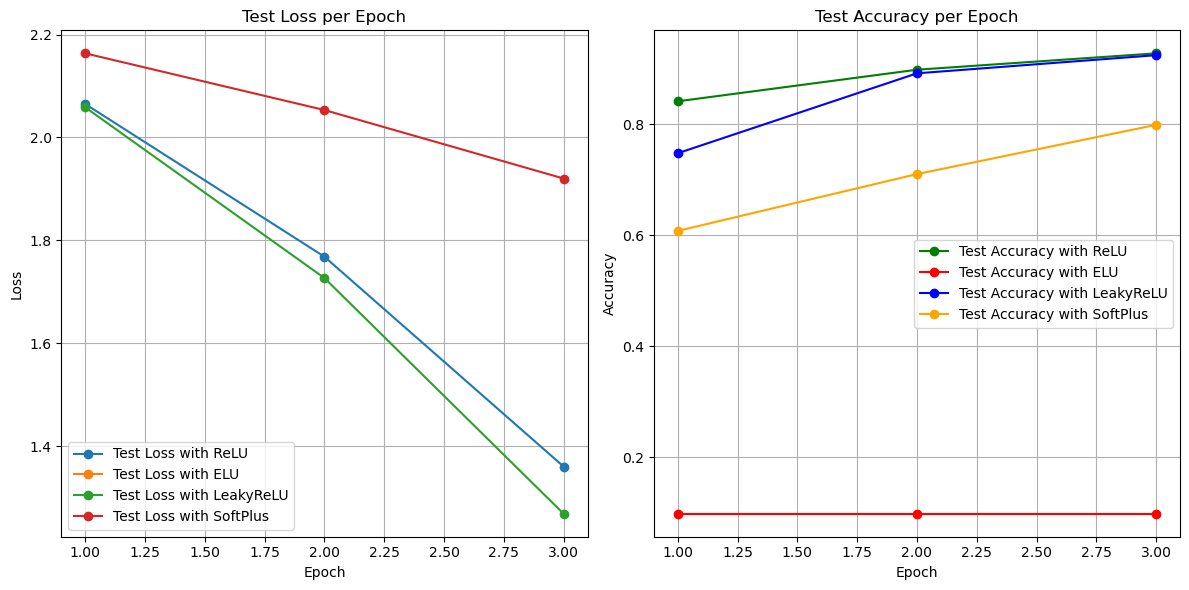

In [29]:
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, len(test_losses_relu) + 1), test_losses_relu, marker='o', label='Test Loss with ReLU')
plt.plot(range(1, len(test_losses_elu) + 1), test_losses_elu, marker='o', label='Test Loss with ELU')
plt.plot(range(1, len(test_losses_leaky) + 1), test_losses_leaky, marker='o', label='Test Loss with LeakyReLU')
plt.plot(range(1, len(test_losses_softplus) + 1), test_losses_softplus, marker='o', label='Test Loss with SoftPlus')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss per Epoch')
plt.grid(True)
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, len(test_accuracies_relu) + 1), test_accuracies_relu, marker='o', color='green', label='Test Accuracy with ReLU')
plt.plot(range(1, len(test_accuracies_elu) + 1), test_accuracies_elu, marker='o', color='red', label='Test Accuracy with ELU')
plt.plot(range(1, len(test_accuracies_leaky) + 1), test_accuracies_leaky, marker='o', color='blue', label='Test Accuracy with LeakyReLU')
plt.plot(range(1, len(test_accuracies_softplus) + 1), test_accuracies_softplus, marker='o', color='orange', label='Test Accuracy with SoftPlus')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy per Epoch')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

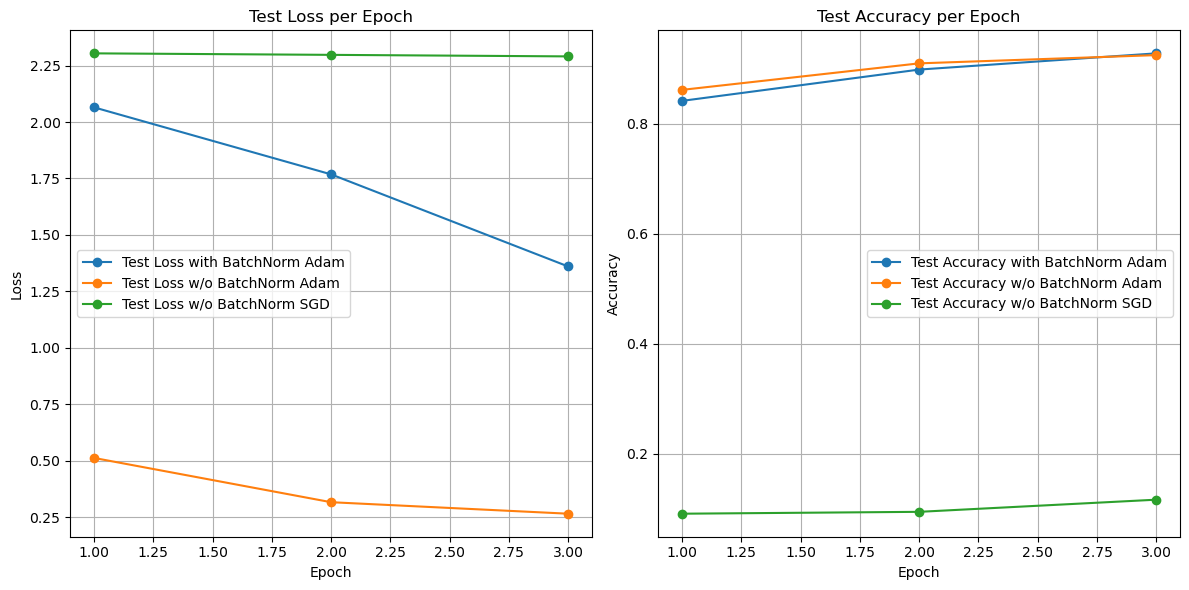

In [30]:
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, len(test_losses_relu) + 1), test_losses_relu, marker='o', label='Test Loss with BatchNorm Adam')
plt.plot(range(1, len(test_losses_relu1) + 1), test_losses_relu1, marker='o', label='Test Loss w/o BatchNorm Adam')
plt.plot(range(1, len(test_losses_relu_sgd) + 1), test_losses_relu_sgd, marker='o', label='Test Loss w/o BatchNorm SGD')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss per Epoch')
plt.grid(True)
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, len(test_accuracies_relu) + 1), test_accuracies_relu, marker='o', label='Test Accuracy with BatchNorm Adam')
plt.plot(range(1, len(test_accuracies_relu1) + 1), test_accuracies_relu1, marker='o',  label='Test Accuracy w/o BatchNorm Adam')
plt.plot(range(1, len(test_accuracies_relu_sgd) + 1), test_accuracies_relu_sgd, marker='o',label='Test Accuracy w/o BatchNorm SGD' )
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy per Epoch')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [ ]:
# Your answer goes here. ################################################

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [ ]:
# Your code goes here. ################################################

Print here your accuracy on test set. It should be around 90%.

In [ ]:
# Your answer goes here. ################################################

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Assuming X_train, X_val, y_train, y_val are already defined

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Flatten the input images
X_train = X_train.view(-1, 784)  # 28x28 = 784
X_val = X_val.view(-1, 784)


# Datasets and dataloaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


# Define the model using only linear layers
class MNISTLinearClassifier(nn.Module):
    def __init__(self):
        super(MNISTLinearClassifier, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Instantiate model, loss, and optimizer
model = MNISTLinearClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")


# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in val_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        _, target_labels = torch.max(target, 1) # Get target labels
        total += target.size(0)
        correct += (predicted == target_labels).sum().item()

    print(f"Test Accuracy: {(100 * correct / total):.2f}%")

Epoch [1/5], Step [100/938], Loss: 0.2551
Epoch [1/5], Step [200/938], Loss: 0.2582
Epoch [1/5], Step [300/938], Loss: 0.1032
Epoch [1/5], Step [400/938], Loss: 0.2216
Epoch [1/5], Step [500/938], Loss: 0.1807
Epoch [1/5], Step [600/938], Loss: 0.0847
Epoch [1/5], Step [700/938], Loss: 0.2138
Epoch [1/5], Step [800/938], Loss: 0.0256
Epoch [1/5], Step [900/938], Loss: 0.1361
Epoch [2/5], Step [100/938], Loss: 0.1305
Epoch [2/5], Step [200/938], Loss: 0.0947
Epoch [2/5], Step [300/938], Loss: 0.0617
Epoch [2/5], Step [400/938], Loss: 0.0401
Epoch [2/5], Step [500/938], Loss: 0.1580
Epoch [2/5], Step [600/938], Loss: 0.1112
Epoch [2/5], Step [700/938], Loss: 0.1305
Epoch [2/5], Step [800/938], Loss: 0.0330
Epoch [2/5], Step [900/938], Loss: 0.0542
Epoch [3/5], Step [100/938], Loss: 0.0811
Epoch [3/5], Step [200/938], Loss: 0.0158
Epoch [3/5], Step [300/938], Loss: 0.0749
Epoch [3/5], Step [400/938], Loss: 0.0225
Epoch [3/5], Step [500/938], Loss: 0.0163
Epoch [3/5], Step [600/938], Loss: